<a href="https://colab.research.google.com/github/AMJAMAITHILI/ML_LAB-141/blob/main/ML_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CatBoost: gradient boosting with categorical features
support**

*Introduction*

The 2018 NeurIPS paper CatBoost: unbiased boosting with categorical features introduced a new
gradient-boosting algorithm that:

Handles categorical features internally rather than using one-hot encoding.

Reduces overfitting by removing gradient bias through an “ordered boosting” scheme.

Provides competitive GPU/CPU implementations faster than XGBoost and LightGBM.

Although CatBoost shows strong results, the paper reports only limited
hyperparameter exploration.
So my goal is to reproduce a baseline Gradient Boosting model, apply CatBoost on the same data,
and demonstrate that systematic hyperparameter tuning further improves CatBoost’s performance
on the Adult Income dataset.

In [3]:
# Install required libraries
!pip install catboost optuna scikit-learn pandas matplotlib --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 35.1 MB/s eta 0:00:00


In [4]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier, Pool
import optuna


In [5]:
import pandas as pd

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]

df = pd.read_csv(url, header=None, names=columns, na_values=" ?", skipinitialspace=True)
print(df.shape)
df.head()


(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
# Basic cleaning: drop rows with missing values
df = df.dropna().reset_index(drop=True)
print("Final shape after dropping NA:", df.shape)


Final shape after dropping NA: (32561, 15)


In [7]:
X = df.drop("income", axis=1)
y = df["income"].apply(lambda x: 1 if x.strip() == ">50K" else 0)

# Identify categorical columns
cat_features = X.select_dtypes(include=["object"]).columns.tolist()
num_features = X.select_dtypes(exclude=["object"]).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Baseline 1 — Gradient Boosting Classifier (scikit-learn default)

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

preprocess = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)],
    remainder="passthrough"
)

gb_baseline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", GradientBoostingClassifier(random_state=42))
])

gb_baseline.fit(X_train, y_train)
y_pred = gb_baseline.predict(X_test)
y_prob = gb_baseline.predict_proba(X_test)[:, 1]

print("GradientBoostingClassifier (default)")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


GradientBoostingClassifier (default)
Accuracy: 0.869031168432366
ROC-AUC: 0.923791683002827


Baseline 2 — CatBoost Classifier (default parameters)

CatBoost handles categorical variables directly, so we do not need to encode them.

In [22]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool  = Pool(X_test,  y_test,  cat_features=cat_features)

cat_default = CatBoostClassifier(
    verbose=0,
    random_seed=42
)
cat_default.fit(train_pool)
y_pred_cat = cat_default.predict(X_test)
y_prob_cat = cat_default.predict_proba(X_test)[:, 1]

print("CatBoostClassifier (default)")
print("Accuracy:", accuracy_score(y_test, y_pred_cat))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_cat))


CatBoostClassifier (default)
Accuracy: 0.8785505911254414
ROC-AUC: 0.932439874331937



Improvement — Hyperparameter Tuning with Optuna

optimizing depth, learning_rate, l2_leaf_reg, and iterations.

In [10]:
from catboost import CatBoostClassifier, Pool, cv
import optuna
import pandas as pd

# Example: categorical columns in Adult dataset
cat_features = ["workclass", "education", "marital-status", "occupation",
                "relationship", "race", "sex", "native-country"]

# Wrap data in Pool
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)

def objective(trial):
    params = {
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "iterations": trial.suggest_int("iterations", 200, 800),
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "random_seed": 42,
        "verbose": 0
    }

    # Use CatBoost cv
    cv_results = cv(
        params=params,
        pool=train_pool,
        fold_count=3,
        verbose=False,
        stratified=True
    )

    # Return the maximum mean test AUC from cross-validation
    return cv_results['test-AUC-mean'].max()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)

print("Best parameters:", study.best_params)
print("Best CV AUC:", study.best_value)


[I 2025-10-05 09:52:03,494] A new study created in memory with name: no-name-51f9d5a5-88f0-4268-99cb-0ec4ebae8070


Training on fold [0/3]

bestTest = 0.9209027768
bestIteration = 219

Training on fold [1/3]

bestTest = 0.9295028277
bestIteration = 218

Training on fold [2/3]


[I 2025-10-05 09:52:26,971] Trial 0 finished with value: 0.9257918432274028 and parameters: {'depth': 4, 'learning_rate': 0.1504566365409458, 'l2_leaf_reg': 5.1185965362552075, 'iterations': 221}. Best is trial 0 with value: 0.9257918432274028.



bestTest = 0.9269789949
bestIteration = 209

Training on fold [0/3]

bestTest = 0.9192920901
bestIteration = 293

Training on fold [1/3]

bestTest = 0.9273807461
bestIteration = 241

Training on fold [2/3]


[I 2025-10-05 09:54:01,462] Trial 1 finished with value: 0.9243116530211206 and parameters: {'depth': 10, 'learning_rate': 0.05596754366675301, 'l2_leaf_reg': 8.658764562772289, 'iterations': 294}. Best is trial 0 with value: 0.9257918432274028.



bestTest = 0.9266553067
bestIteration = 287

Training on fold [0/3]

bestTest = 0.9210574503
bestIteration = 332

Training on fold [1/3]

bestTest = 0.928300154
bestIteration = 201

Training on fold [2/3]


[I 2025-10-05 09:55:05,092] Trial 2 finished with value: 0.9255104891850842 and parameters: {'depth': 8, 'learning_rate': 0.07004974169129, 'l2_leaf_reg': 3.167516148053057, 'iterations': 366}. Best is trial 0 with value: 0.9257918432274028.



bestTest = 0.9277265761
bestIteration = 328

Training on fold [0/3]

bestTest = 0.9216328329
bestIteration = 554

Training on fold [1/3]

bestTest = 0.9290727961
bestIteration = 181

Training on fold [2/3]


[I 2025-10-05 09:56:43,380] Trial 3 finished with value: 0.9259095521062838 and parameters: {'depth': 7, 'learning_rate': 0.07776752376561653, 'l2_leaf_reg': 3.035604093394182, 'iterations': 688}. Best is trial 3 with value: 0.9259095521062838.



bestTest = 0.9277915895
bestIteration = 405

Training on fold [0/3]

bestTest = 0.9169888548
bestIteration = 60

Training on fold [1/3]

bestTest = 0.9227390533
bestIteration = 17

Training on fold [2/3]


[I 2025-10-05 09:58:09,352] Trial 4 finished with value: 0.9200167540087812 and parameters: {'depth': 10, 'learning_rate': 0.2821493880511317, 'l2_leaf_reg': 2.3196908112188095, 'iterations': 254}. Best is trial 3 with value: 0.9259095521062838.



bestTest = 0.9227839638
bestIteration = 51

Training on fold [0/3]

bestTest = 0.9227600924
bestIteration = 591

Training on fold [1/3]

bestTest = 0.9292584478
bestIteration = 444

Training on fold [2/3]


[I 2025-10-05 09:59:16,108] Trial 5 finished with value: 0.9268037592219192 and parameters: {'depth': 5, 'learning_rate': 0.0873777287310142, 'l2_leaf_reg': 3.591318830023826, 'iterations': 654}. Best is trial 5 with value: 0.9268037592219192.



bestTest = 0.9285890916
bestIteration = 648

Training on fold [0/3]

bestTest = 0.9227553767
bestIteration = 278

Training on fold [1/3]

bestTest = 0.9279599738
bestIteration = 97

Training on fold [2/3]


[I 2025-10-05 09:59:57,411] Trial 6 finished with value: 0.9258182616812638 and parameters: {'depth': 5, 'learning_rate': 0.28627330710398785, 'l2_leaf_reg': 6.981513395314929, 'iterations': 423}. Best is trial 5 with value: 0.9268037592219192.



bestTest = 0.9281438662
bestIteration = 341

Training on fold [0/3]

bestTest = 0.922499244
bestIteration = 610

Training on fold [1/3]

bestTest = 0.9298179423
bestIteration = 378

Training on fold [2/3]


[I 2025-10-05 10:01:08,953] Trial 7 finished with value: 0.926829921963495 and parameters: {'depth': 6, 'learning_rate': 0.05213340202097124, 'l2_leaf_reg': 2.558421716238695, 'iterations': 615}. Best is trial 7 with value: 0.926829921963495.



bestTest = 0.9285176205
bestIteration = 614

Training on fold [0/3]

bestTest = 0.9184827747
bestIteration = 110

Training on fold [1/3]

bestTest = 0.9254778338
bestIteration = 39

Training on fold [2/3]


[I 2025-10-05 10:04:59,762] Trial 8 finished with value: 0.9225478960874464 and parameters: {'depth': 10, 'learning_rate': 0.19388483533759512, 'l2_leaf_reg': 6.829989784475509, 'iterations': 662}. Best is trial 7 with value: 0.926829921963495.



bestTest = 0.9246225869
bestIteration = 91

Training on fold [0/3]

bestTest = 0.9210060497
bestIteration = 306

Training on fold [1/3]

bestTest = 0.9285387299
bestIteration = 218

Training on fold [2/3]


[I 2025-10-05 10:05:26,824] Trial 9 finished with value: 0.9255322484351884 and parameters: {'depth': 4, 'learning_rate': 0.11558649161997221, 'l2_leaf_reg': 8.253944518380194, 'iterations': 310}. Best is trial 7 with value: 0.926829921963495.



bestTest = 0.9271319505
bestIteration = 309

Training on fold [0/3]

bestTest = 0.9172021113
bestIteration = 791

Training on fold [1/3]

bestTest = 0.9277047843
bestIteration = 797

Training on fold [2/3]


[I 2025-10-05 10:07:42,199] Trial 10 finished with value: 0.9232027132110355 and parameters: {'depth': 8, 'learning_rate': 0.012716658515354723, 'l2_leaf_reg': 1.6294924189021147, 'iterations': 799}. Best is trial 7 with value: 0.926829921963495.



bestTest = 0.9247196716
bestIteration = 795

Training on fold [0/3]

bestTest = 0.9192928155
bestIteration = 557

Training on fold [1/3]

bestTest = 0.9285105085
bestIteration = 557

Training on fold [2/3]


[I 2025-10-05 10:08:47,582] Trial 11 finished with value: 0.9247220719211203 and parameters: {'depth': 6, 'learning_rate': 0.023796433641013668, 'l2_leaf_reg': 4.54030871563178, 'iterations': 558}. Best is trial 7 with value: 0.926829921963495.



bestTest = 0.9263628917
bestIteration = 557

Training on fold [0/3]

bestTest = 0.9223196864
bestIteration = 377

Training on fold [1/3]

bestTest = 0.9296951901
bestIteration = 258

Training on fold [2/3]


[I 2025-10-05 10:09:52,662] Trial 12 finished with value: 0.926453911133852 and parameters: {'depth': 6, 'learning_rate': 0.11680239557421493, 'l2_leaf_reg': 4.100929443234719, 'iterations': 554}. Best is trial 7 with value: 0.926829921963495.



bestTest = 0.9279778862
bestIteration = 277

Training on fold [0/3]

bestTest = 0.9208296841
bestIteration = 95

Training on fold [1/3]

bestTest = 0.9285090938
bestIteration = 102

Training on fold [2/3]


[I 2025-10-05 10:11:11,959] Trial 13 finished with value: 0.9254849412955415 and parameters: {'depth': 6, 'learning_rate': 0.2086537210518639, 'l2_leaf_reg': 1.6481599560837532, 'iterations': 658}. Best is trial 7 with value: 0.926829921963495.



bestTest = 0.9273126964
bestIteration = 130

Training on fold [0/3]

bestTest = 0.9231051333
bestIteration = 689

Training on fold [1/3]

bestTest = 0.929791317
bestIteration = 322

Training on fold [2/3]


[I 2025-10-05 10:12:29,050] Trial 14 finished with value: 0.9267124753645374 and parameters: {'depth': 5, 'learning_rate': 0.106690599427464, 'l2_leaf_reg': 1.0254489111937, 'iterations': 766}. Best is trial 7 with value: 0.926829921963495.



bestTest = 0.9283702883
bestIteration = 462

Training on fold [0/3]

bestTest = 0.9212148081
bestIteration = 495

Training on fold [1/3]

bestTest = 0.9296212269
bestIteration = 477

Training on fold [2/3]


[I 2025-10-05 10:13:16,828] Trial 15 finished with value: 0.9260007229525873 and parameters: {'depth': 5, 'learning_rate': 0.045479790195666316, 'l2_leaf_reg': 3.6080337054271094, 'iterations': 497}. Best is trial 7 with value: 0.926829921963495.



bestTest = 0.9272316836
bestIteration = 486

Training on fold [0/3]

bestTest = 0.9214597683
bestIteration = 230

Training on fold [1/3]

bestTest = 0.9278858655
bestIteration = 150

Training on fold [2/3]


[I 2025-10-05 10:14:40,708] Trial 16 finished with value: 0.9253506310687079 and parameters: {'depth': 7, 'learning_rate': 0.15386606638316608, 'l2_leaf_reg': 5.9919265428118464, 'iterations': 589}. Best is trial 7 with value: 0.926829921963495.



bestTest = 0.9270395822
bestIteration = 237

Training on fold [0/3]

bestTest = 0.9214436988
bestIteration = 416

Training on fold [1/3]

bestTest = 0.928139205
bestIteration = 274

Training on fold [2/3]


[I 2025-10-05 10:16:01,649] Trial 17 finished with value: 0.9256040039701636 and parameters: {'depth': 8, 'learning_rate': 0.08731327122364774, 'l2_leaf_reg': 9.820619434900333, 'iterations': 472}. Best is trial 7 with value: 0.926829921963495.



bestTest = 0.9277560716
bestIteration = 339

Training on fold [0/3]

bestTest = 0.9230565258
bestIteration = 368

Training on fold [1/3]

bestTest = 0.9308687356
bestIteration = 235

Training on fold [2/3]


[I 2025-10-05 10:17:01,740] Trial 18 finished with value: 0.9270566813247115 and parameters: {'depth': 4, 'learning_rate': 0.19703747354789575, 'l2_leaf_reg': 2.4724251168410945, 'iterations': 715}. Best is trial 18 with value: 0.9270566813247115.



bestTest = 0.9279771969
bestIteration = 374

Training on fold [0/3]

bestTest = 0.9217544243
bestIteration = 232

Training on fold [1/3]

bestTest = 0.9304726567
bestIteration = 342

Training on fold [2/3]


[I 2025-10-05 10:18:03,942] Trial 19 finished with value: 0.9266837953260499 and parameters: {'depth': 4, 'learning_rate': 0.23737369260632085, 'l2_leaf_reg': 2.451054683795518, 'iterations': 724}. Best is trial 18 with value: 0.9270566813247115.



bestTest = 0.9283443482
bestIteration = 305

Training on fold [0/3]

bestTest = 0.9198539423
bestIteration = 100

Training on fold [1/3]

bestTest = 0.9261844567
bestIteration = 67

Training on fold [2/3]


[I 2025-10-05 10:21:02,203] Trial 20 finished with value: 0.9236502982409563 and parameters: {'depth': 9, 'learning_rate': 0.1771761191208093, 'l2_leaf_reg': 5.2475110352928915, 'iterations': 733}. Best is trial 18 with value: 0.9270566813247115.



bestTest = 0.9264737627
bestIteration = 113

Training on fold [0/3]

bestTest = 0.9233323554
bestIteration = 226

Training on fold [1/3]

bestTest = 0.9290794343
bestIteration = 210

Training on fold [2/3]


[I 2025-10-05 10:22:02,872] Trial 21 finished with value: 0.9264483684139538 and parameters: {'depth': 5, 'learning_rate': 0.2400041226961372, 'l2_leaf_reg': 2.5241087144849086, 'iterations': 610}. Best is trial 18 with value: 0.9270566813247115.



bestTest = 0.9275099495
bestIteration = 216

Training on fold [0/3]

bestTest = 0.9215324257
bestIteration = 651

Training on fold [1/3]

bestTest = 0.9292844565
bestIteration = 494

Training on fold [2/3]


[I 2025-10-05 10:23:18,643] Trial 22 finished with value: 0.9263296682839783 and parameters: {'depth': 6, 'learning_rate': 0.04365165193050978, 'l2_leaf_reg': 3.9701101084871615, 'iterations': 654}. Best is trial 18 with value: 0.9270566813247115.



bestTest = 0.9283750772
bestIteration = 647

Training on fold [0/3]

bestTest = 0.923608185
bestIteration = 581

Training on fold [1/3]

bestTest = 0.9300933366
bestIteration = 575

Training on fold [2/3]


[I 2025-10-05 10:24:09,698] Trial 23 finished with value: 0.9271960235660112 and parameters: {'depth': 4, 'learning_rate': 0.13665986440279793, 'l2_leaf_reg': 3.1866245311176273, 'iterations': 612}. Best is trial 23 with value: 0.9271960235660112.



bestTest = 0.9281593939
bestIteration = 496

Training on fold [0/3]

bestTest = 0.9220263726
bestIteration = 419

Training on fold [1/3]

bestTest = 0.9305332711
bestIteration = 204

Training on fold [2/3]


[I 2025-10-05 10:25:00,392] Trial 24 finished with value: 0.9269275860375842 and parameters: {'depth': 4, 'learning_rate': 0.12949522723456397, 'l2_leaf_reg': 1.0467952514756598, 'iterations': 603}. Best is trial 23 with value: 0.9271960235660112.



bestTest = 0.9287889207
bestIteration = 439

Best parameters: {'depth': 4, 'learning_rate': 0.13665986440279793, 'l2_leaf_reg': 3.1866245311176273, 'iterations': 612}
Best CV AUC: 0.9271960235660112


Training CatBoost with the best parameters->

In [23]:
best_params = study.best_params
cat_tuned = CatBoostClassifier(**best_params, verbose=0)
cat_tuned.fit(train_pool)

y_pred_tuned = cat_tuned.predict(X_test)
y_prob_tuned = cat_tuned.predict_proba(X_test)[:, 1]

print("CatBoost (tuned)")
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_tuned))


CatBoost (tuned)
Accuracy: 0.8780899738983571
ROC-AUC: 0.9333453705041166


Evaluation and Visualization
ROC Curve Comparison->

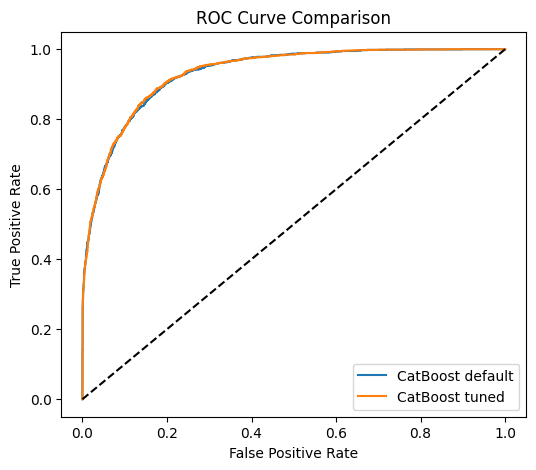

In [24]:
fpr_base, tpr_base, _ = roc_curve(y_test, y_prob_cat)
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_prob_tuned)

plt.figure(figsize=(6,5))
plt.plot(fpr_base, tpr_base, label="CatBoost default")
plt.plot(fpr_tuned, tpr_tuned, label="CatBoost tuned")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


Feature Importance->

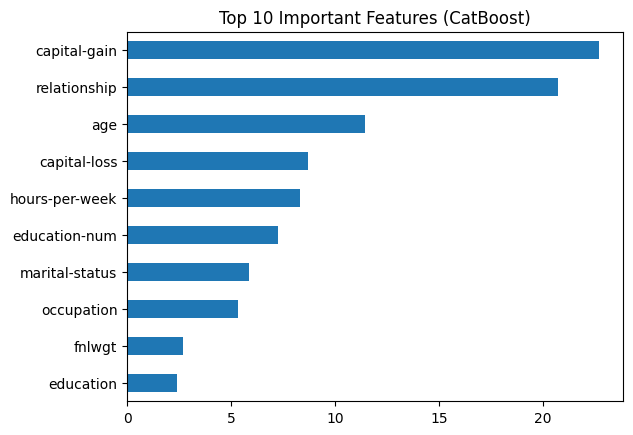

In [25]:
feature_importances = pd.Series(cat_tuned.get_feature_importance(), index=X_train.columns)
feature_importances.sort_values(ascending=False).head(10).plot.barh()
plt.title("Top 10 Important Features (CatBoost)")
plt.gca().invert_yaxis()
plt.show()
